In [1]:
from scipy.stats import sem
from sklearn.metrics import auc, roc_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_with_cv(y_test, y_pred_prob, title, n_bootstraps=1000, rng_seed=42):
    # Initialize lists to hold ROC curve values
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    # Perform bootstrap resampling
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred_prob), len(y_pred_prob))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        fpr, tpr, _ = roc_curve(y_test[indices], y_pred_prob[indices])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(mean_fpr, interp_tpr))

    # Calculate mean and std for tpr
    mean_tpr = np.mean(tprs, axis=0)
    std = np.std(tprs, axis=0)

    # Calculate upper and lower limit for tpr
    tprs_upper = np.minimum(mean_tpr + std, 1)
    tprs_lower = mean_tpr - std

    # Calculate mean auc
    mean_auc = auc(mean_fpr, mean_tpr)

    # Calculate std for auc
    std_auc = np.std(aucs)

    # Plot the result
    plt.figure(figsize=(10, 10))

    # ROC curve and AUC score with confidence interval
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Diagonal line
    plt.plot([0, 1], [0, 1], 'k--')

    # Upper and lower limit of tpr
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


AUC scores: [0.72916667 0.875      0.87777778 0.85       0.6125    ]
Average AUC score: 0.7888888888888889


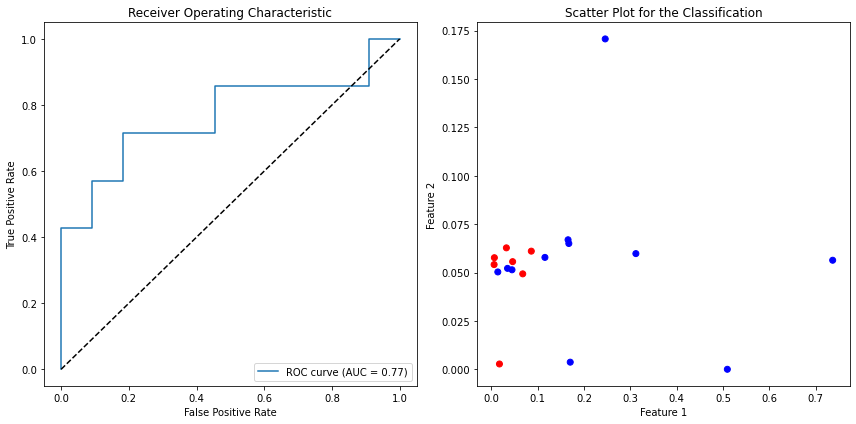

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load the two excel files into pandas DataFrames
df1 = pd.read_excel('Analysis2_2024Jan_1.xlsx', header=None)  
df2 = pd.read_excel('Analysis2_2024Jan_0.xlsx', header=None)  
# Convert the dataframes to numpy arrays
array1 = df1.values
array2 = df2.values

# Stack the two arrays vertically
combined_array = np.vstack((array1, array2))

# Replace Inf values with NaN
combined_array[np.isinf(combined_array)] = np.nan
# Remove rows with any NaN values
combined_array = combined_array[~np.isnan(combined_array).any(axis=1)]

# Calculate z-scores
z_scores = np.abs(stats.zscore(combined_array))

# Get indices of outliers 
outliers = np.where(np.any(z_scores > 3, axis=1))

# Remove outliers
combined_array = np.delete(combined_array, outliers, axis=0)

# Split the data into features and target variable
X = combined_array[:, 2:-1]
# X = combined_array[:, [2,3, 4, 5, 6, 7, 8, 9]]
# X = combined_array[:, :-1]
y = combined_array[:, -1]

# normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVM model
# model = SVC(probability=True)
# model = LogisticRegression()
model = RandomForestClassifier()
# Train the model
model.fit(X_train, y_train)

# Cross-validation and calculate the AUC score
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print('AUC scores:', cv_scores)
print('Average AUC score:', np.mean(cv_scores))

# Generate ROC curve values: fpr, tpr, thresholds
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# AUC score without cross-validation
auc_score = auc(fpr, tpr)


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ROC curve on the first subplot
ax1.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
ax1.plot([0, 1], [0, 1], 'k--')  # Diagonal line
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc='lower right')

# Plot the scatter plot on the second subplot
colors = {0: 'red', 1: 'blue'}
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.get_cmap('bwr'))
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_title('Scatter Plot for the Classification')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


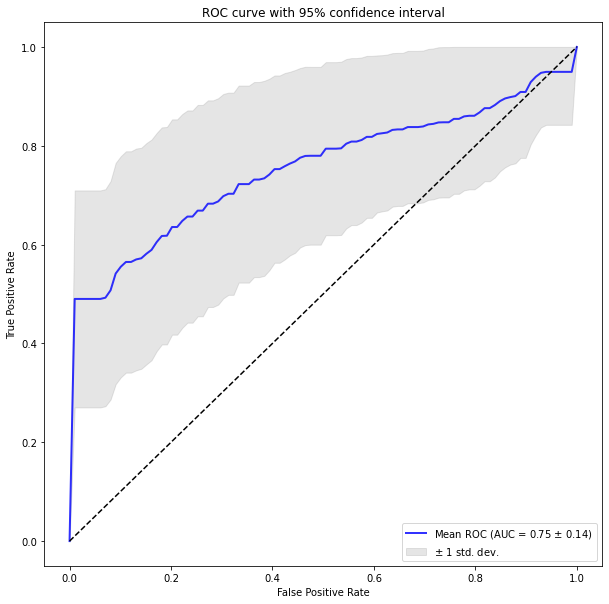

In [3]:
plot_roc_with_cv(y_test, y_pred_prob, 'ROC curve with 95% confidence interval')

## Do the feature seletion for top 8 features

AUC scores: [0.92708333 0.9375     0.97777778 0.9625     0.7       ]
Average AUC score: 0.9009722222222223


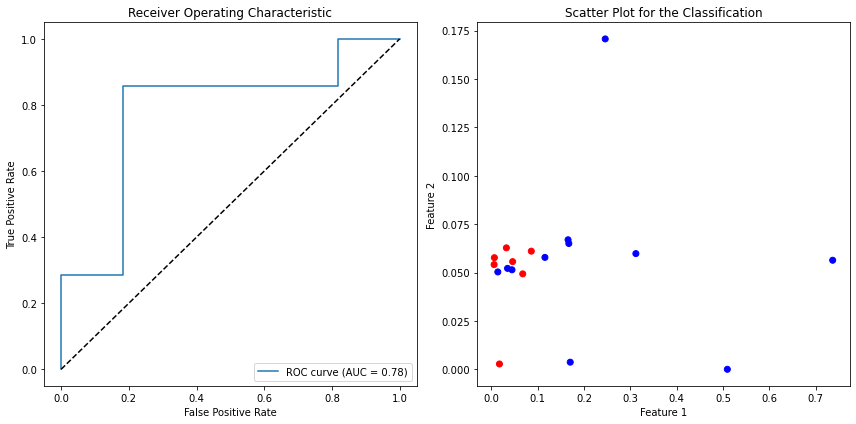

In [4]:


# Load the two excel files into pandas DataFrames
df1 = pd.read_excel('Analysis2_2024Jan_1.xlsx', header=None)  
df2 = pd.read_excel('Analysis2_2024Jan_0.xlsx', header=None)  

# Convert the dataframes to numpy arrays
array1 = df1.values
array2 = df2.values

# Stack the two arrays vertically
combined_array = np.vstack((array1, array2))

# Replace Inf values with NaN
combined_array[np.isinf(combined_array)] = np.nan
# Remove rows with any NaN values
combined_array = combined_array[~np.isnan(combined_array).any(axis=1)]

# Calculate z-scores
z_scores = np.abs(stats.zscore(combined_array))

# Get indices of outliers 
outliers = np.where(np.any(z_scores > 3, axis=1))

# Remove outliers
combined_array = np.delete(combined_array, outliers, axis=0)

# Using all features to train the RandomForest model
X = combined_array[:, 2:-1]
y = combined_array[:, -1]

# normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForest model with all features
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Get the indices of the top 8 important features
indices_top8 = importances.argsort()[-8:][::-1]

# Select the top 8 features
X_train_top8 = X_train[:, indices_top8]
X_test_top8 = X_test[:, indices_top8]

# Re-train the model using only top 8 features
model.fit(X_train_top8, y_train)

# Cross-validation and calculate the AUC score
cv_scores = cross_val_score(model, X_train_top8, y_train, cv=5, scoring='roc_auc')
print('AUC scores:', cv_scores)
print('Average AUC score:', np.mean(cv_scores))

# Generate ROC curve values: fpr, tpr, thresholds
y_pred_prob = model.predict_proba(X_test_top8)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# AUC score without cross-validation
auc_score = auc(fpr, tpr)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ROC curve on the first subplot
ax1.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
ax1.plot([0, 1], [0, 1], 'k--')  # Diagonal line
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc='lower right')

# Plot the scatter plot on the second subplot
colors = {0: 'red', 1: 'blue'}
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.get_cmap('bwr'))
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_title('Scatter Plot for the Classification')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

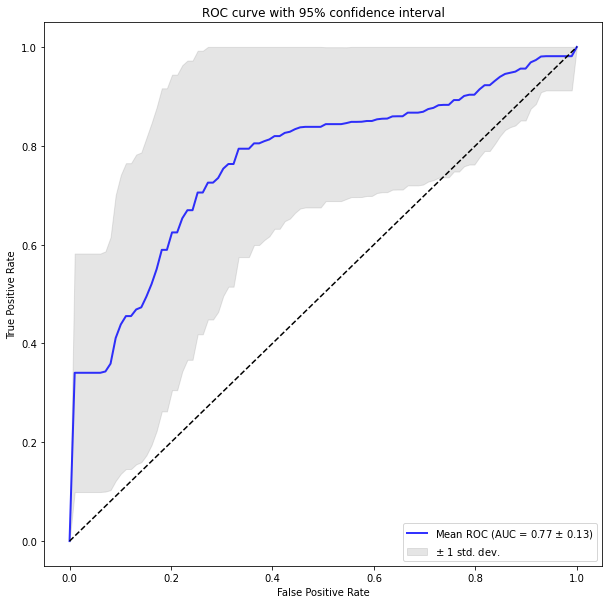

In [5]:
plot_roc_with_cv(y_test, y_pred_prob, 'ROC curve with 95% confidence interval')

In [6]:
indices_top8

array([19,  1, 15, 36,  5,  7, 10, 32])

# Apply PCA and LDA

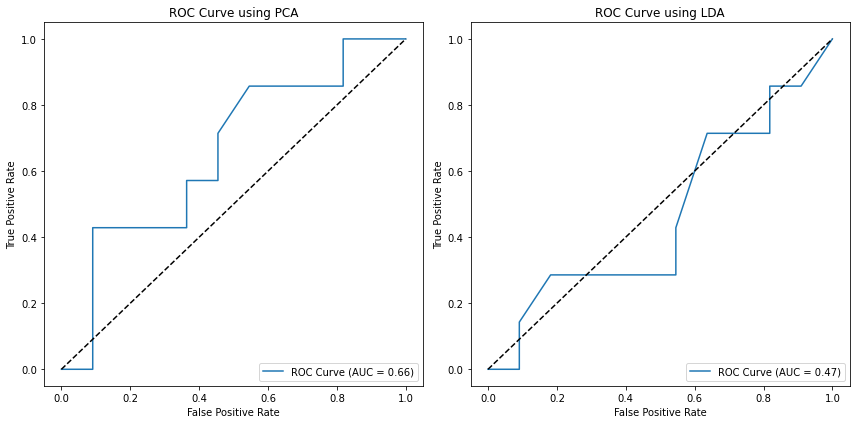

In [5]:
# 应用PCA
pca = PCA(n_components=2)
X_train_top8_pca = pca.fit_transform(X_train_top8)
X_test_top8_pca = pca.transform(X_test_top8)

# 训练使用PCA转换后的数据的随机森林模型
model_pca = RandomForestClassifier()
model_pca.fit(X_train_top8_pca, y_train)

# 评估PCA模型
y_pred_prob_pca = model_pca.predict_proba(X_test_top8_pca)[:,1]
fpr_pca, tpr_pca, _ = roc_curve(y_test, y_pred_prob_pca)
auc_score_pca = auc(fpr_pca, tpr_pca)

# 应用LDA
lda = LDA(n_components=1)
X_train_top8_lda = lda.fit_transform(X_train_top8, y_train)
X_test_top8_lda = lda.transform(X_test_top8)

# 训练使用LDA转换后的数据的随机森林模型
model_lda = RandomForestClassifier()
model_lda.fit(X_train_top8_lda, y_train)

# 评估LDA模型
y_pred_prob_lda = model_lda.predict_proba(X_test_top8_lda)[:,1]
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_pred_prob_lda)
auc_score_lda = auc(fpr_lda, tpr_lda)

# 创建图表
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 绘制PCA的ROC曲线
axs[0].plot(fpr_pca, tpr_pca, label=f'ROC Curve (AUC = {auc_score_pca:.2f})')
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve using PCA')
axs[0].legend(loc='lower right')

# 绘制LDA的ROC曲线
axs[1].plot(fpr_lda, tpr_lda, label=f'ROC Curve (AUC = {auc_score_lda:.2f})')
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve using LDA')
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


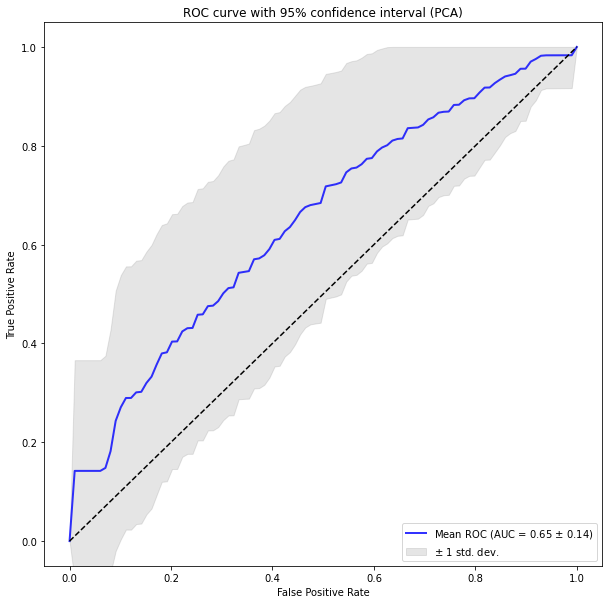

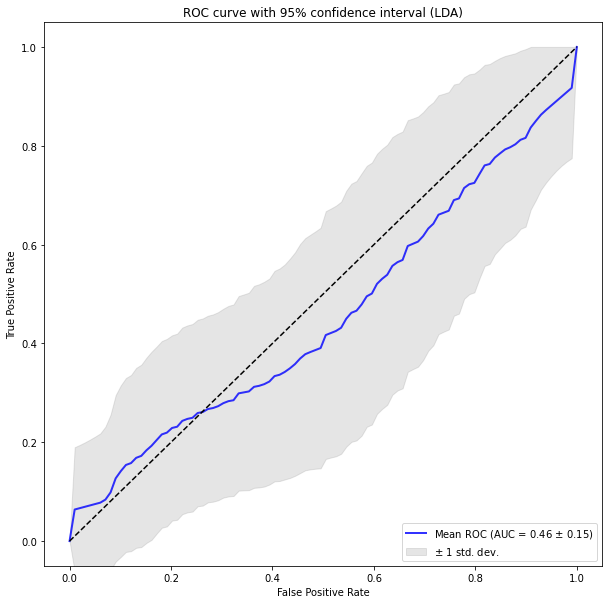

In [6]:
plot_roc_with_cv(y_test, y_pred_prob_pca, 'ROC curve with 95% confidence interval (PCA)')
plot_roc_with_cv(y_test, y_pred_prob_lda, 'ROC curve with 95% confidence interval (LDA)')

# Autogluon

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from autogluon.tabular import TabularPredictor

# 1. 加载数据，假设最后一列是目标列
df1 = pd.read_excel('Analysis2_2024Jan_1.xlsx', header=None)  
df2 = pd.read_excel('Analysis2_2024Jan_0.xlsx', header=None)  

# 2. 数据预处理
# 合并数据
combined_df = pd.concat([df1, df2], axis=0)

# 替换无穷大值为 NaN
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 移除包含 NaN 的行
combined_df.dropna(inplace=True)

# 计算 z-scores 并移除异常值
z_scores = np.abs(stats.zscore(combined_df))
combined_df = combined_df[(z_scores < 3).all(axis=1)]

# 3. 数据划分
X = combined_df.iloc[:, 2:-1]  # 假设最后一列是目标列
y = combined_df.iloc[:, -1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征缩放
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 重置列名以避免重复
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=[f'feature{i}' for i in range(X_train_scaled.shape[1])])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=[f'feature{i}' for i in range(X_test_scaled.shape[1])])

# 合并目标列
train_data_df = X_train_scaled_df.assign(target=y_train.reset_index(drop=True))
test_data_df = X_test_scaled_df.assign(target=y_test.reset_index(drop=True))

# 使用 AutoGluon 训练模型
predictor = TabularPredictor(label='target', eval_metric='roc_auc').fit(
    train_data=train_data_df,
    tuning_data=test_data_df,
    time_limit=300
)



# 在测试集上评估模型性能
performance = predictor.evaluate(test_data_df)

print(performance)


No path specified. Models will be saved in: "AutogluonModels/ag-20240124_055340/"
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20240124_055340/"
AutoGluon Version:  0.8.2
Python Version:     3.8.8
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64
Disk Space Avail:   44.14 GB / 1000.24 GB (4.4%)
Train Data Rows:    68
Train Data Columns: 38
Tuning Data Rows:    18
Tuning Data Columns: 38
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class

{'roc_auc': 0.7922077922077922, 'accuracy': 0.7777777777777778, 'balanced_accuracy': 0.7922077922077921, 'mcc': 0.5698028822981898, 'f1': 0.75, 'precision': 0.6666666666666666, 'recall': 0.8571428571428571}


Predict_proba columns: Int64Index([0, 1], dtype='int64')


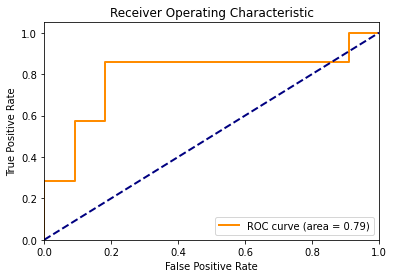

In [8]:
# 获取测试集上的预测概率
y_pred_proba_df = predictor.predict_proba(test_data_df.drop(columns=['target']))

# 检查预测概率 DataFrame 的列名
print("Predict_proba columns:", y_pred_proba_df.columns)

# 如果 DataFrame 列名是字符串形式的 '0' 和 '1'，选择 '1'
# 如果列名是数字 0 和 1，选择 1
# 根据实际情况调整下面的列名
y_pred_prob = y_pred_proba_df[1]  # 或 y_pred_proba_df['1']，根据实际列名调整

# 计算 ROC 曲线的值
fpr, tpr, thresholds = roc_curve(test_data_df['target'], y_pred_prob)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


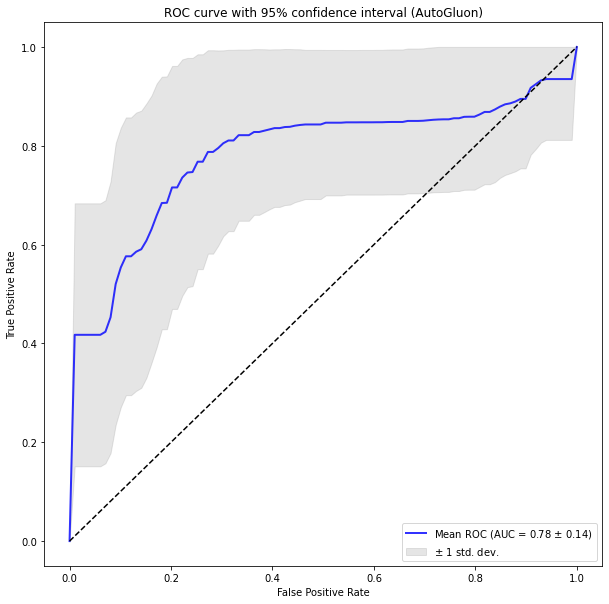

In [9]:
# 重置 y_test 的索引，以确保索引是连续的整数
y_test_reset = y_test.reset_index(drop=True)

# 使用 plot_roc_with_cv 函数绘制带误差条的 ROC 曲线
plot_roc_with_cv(y_test_reset, y_pred_prob, 'ROC curve with 95% confidence interval (AutoGluon)')